# Notatki

 * Jakbyśmy mieli do czynienia z ciagłym przypływem próbek bez żadnych przerw to moglibyśmy pozwolić sobie na dropnięcie czasu
 * Lepiej celować w wielkość typu 200-400 time steps w LSTM(patrz: [źródło](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/))

# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

3.7.4


# Załadowanie danych

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


In [3]:
%ls -l data

 Volume in drive D is Data
 Volume Serial Number is 82E7-60C3

 Directory of D:\Studia\Auto_Tag


 Directory of D:\Studia\Auto_Tag\data

12.06.2020  23:49    <DIR>          .
12.06.2020  23:49    <DIR>          ..
04.05.2020  12:59           286˙105 data_real_5s.csv
12.06.2020  23:48        25˙470˙109 data_real_5s_without_step_12_06.csv
12.06.2020  23:49        26˙350˙265 data_real_5s_without_step_12_06_normalized.csv
26.05.2020  07:13        16˙127˙004 data_real_5s_without_step_25_05.csv
08.06.2020  20:00        16˙255˙634 data_real_5s_without_step_25_05_normalized.csv
09.04.2020  16:52         1˙076˙355 easy.csv
09.04.2020  16:52         2˙924˙235 hard.csv
09.04.2020  16:52         2˙787˙990 medium.csv
04.05.2020  14:29         3˙955˙274 rawData.csv
               9 File(s)     95˙232˙971 bytes
               2 Dir(s)  251˙730˙395˙136 bytes free


File Not Found


In [4]:
data_type = '5s_new' # '5s' or '5s_new' or 'raw'

if data_type == 'raw':
    df = pd.read_csv("data//rawData.csv")
    tmp = df.pop('target')
    df['activity'] = tmp
else:
    df = pd.read_csv("data//data_real_5s_without_step_25_05_normalized.csv", index_col = 0)
    tmp = df.pop('activity')
    df['activity'] = tmp
    
df.dropna(inplace=True)



In [5]:
df.head()

,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max,activity
0,0.141273,0.204761,0.341955,0.141973,0.231727,0.188443,0.123579,0.201863,0.222241,0.228852,0.134751,0.337155,cooking
1,0.129883,0.198363,0.341955,0.141973,0.314287,0.340086,0.254777,0.377826,0.206203,0.211486,0.119202,0.337155,cooking
2,0.141269,0.205197,0.341955,0.141973,0.334829,0.341756,0.254777,0.377826,0.182096,0.211651,0.013535,0.287161,cooking
3,0.129458,0.195688,0.341955,0.141973,0.329131,0.343515,0.254777,0.377826,0.162097,0.214452,0.013535,0.221466,cooking
4,0.126727,0.196057,0.341955,0.141973,0.314288,0.345102,0.254777,0.377826,0.148369,0.231137,0.013535,0.221466,cooking


In [6]:
'''
from datetime import datetime

# zmiana timestampów na UNIXowe
timestamps = []

for i in df['timestamp']:
    now = i
    now = datetime.strptime(now, '%Y-%m-%d %H:%M:%S')
    timestamp = datetime.timestamp(now)
    timestamps.append(timestamp)

df['timestamp'] = timestamps
'''

# ciągły czas
if data_type == '5s':
    df.drop(columns = ['timestamp'], inplace = True)

In [7]:
df.head()

,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max,activity
0,0.141273,0.204761,0.341955,0.141973,0.231727,0.188443,0.123579,0.201863,0.222241,0.228852,0.134751,0.337155,cooking
1,0.129883,0.198363,0.341955,0.141973,0.314287,0.340086,0.254777,0.377826,0.206203,0.211486,0.119202,0.337155,cooking
2,0.141269,0.205197,0.341955,0.141973,0.334829,0.341756,0.254777,0.377826,0.182096,0.211651,0.013535,0.287161,cooking
3,0.129458,0.195688,0.341955,0.141973,0.329131,0.343515,0.254777,0.377826,0.162097,0.214452,0.013535,0.221466,cooking
4,0.126727,0.196057,0.341955,0.141973,0.314288,0.345102,0.254777,0.377826,0.148369,0.231137,0.013535,0.221466,cooking


In [8]:
'''
Wygląd danych:

|     Nazwa     | Ilość pól |
| :-----------: | :-------: |
|   timestamp   |     1     |
| accelerometer |     4     |
|   gyroscope   |     4     |
|  magnetometer |     4     |
|    activity   |     1     |


Suma: 14

'''


df.shape

(63812, 13)

# Obróbka danych

In [9]:
'''
Zmiana activity na liczby:

0 - cooking
1 - driving
2 - sitting
3 - sport
4 - walking
'''
df.activity.unique()

array(['cooking', 'driving', 'sitting', 'walking', 'sport'], dtype=object)

In [10]:
df = df.replace({'activity':'cooking'},{'activity':0})
df = df.replace({'activity':'driving'},{'activity':1})
df = df.replace({'activity':'sitting'},{'activity':2})
df = df.replace({'activity':'sport'},{'activity':3})
df = df.replace({'activity':'walking'},{'activity':4})

In [11]:
'''
Podział danych z całego df na X i y:

X - wszystko oprócz activity(time, accelerometer,gyroscope, sound) 
y - activity
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [12]:
df.head()

,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max,activity
0,0.141273,0.204761,0.341955,0.141973,0.231727,0.188443,0.123579,0.201863,0.222241,0.228852,0.134751,0.337155,0
1,0.129883,0.198363,0.341955,0.141973,0.314287,0.340086,0.254777,0.377826,0.206203,0.211486,0.119202,0.337155,0
2,0.141269,0.205197,0.341955,0.141973,0.334829,0.341756,0.254777,0.377826,0.182096,0.211651,0.013535,0.287161,0
3,0.129458,0.195688,0.341955,0.141973,0.329131,0.343515,0.254777,0.377826,0.162097,0.214452,0.013535,0.221466,0
4,0.126727,0.196057,0.341955,0.141973,0.314288,0.345102,0.254777,0.377826,0.148369,0.231137,0.013535,0.221466,0


In [13]:
X.head()

,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max
0,0.141273,0.204761,0.341955,0.141973,0.231727,0.188443,0.123579,0.201863,0.222241,0.228852,0.134751,0.337155
1,0.129883,0.198363,0.341955,0.141973,0.314287,0.340086,0.254777,0.377826,0.206203,0.211486,0.119202,0.337155
2,0.141269,0.205197,0.341955,0.141973,0.334829,0.341756,0.254777,0.377826,0.182096,0.211651,0.013535,0.287161
3,0.129458,0.195688,0.341955,0.141973,0.329131,0.343515,0.254777,0.377826,0.162097,0.214452,0.013535,0.221466
4,0.126727,0.196057,0.341955,0.141973,0.314288,0.345102,0.254777,0.377826,0.148369,0.231137,0.013535,0.221466


In [14]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: activity, dtype: int64

# Podział na dane testowe i treningowe

In [15]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych(4714)
test  - 20% danych(1179)
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

'''
Podział na X_train, y_train, X_test, y_test

X_train, X_test - bez 'activity'
y_train, y_test - sam 'activity' dla X_train, X_test
'''
X_train = train.drop('activity', axis = 1)
y_train = train.activity

X_test = test.drop('activity', axis = 1)
y_test = test.activity

In [16]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 12)
	 y_train: (51049,)
	 X_test: (12763, 12)
	 y_test: (12763,)


In [17]:
# Konwersja danych z pandas dataframe do numpy

df = df.to_numpy()

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [18]:
# Upewnienie się że dane w X_train i X_test są floatem - lepsze dla klasyfikatora

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [19]:
num_classes = 5

# Zamiana wpisu z [1] na [0, 1, 0, 0, 0]
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [20]:
# Upewnienie się że dane w y_train i y_test są floatem - lepsze dla klasyfikatora

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [21]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 12)
	 y_train: (51049, 5)
	 X_test: (12763, 12)
	 y_test: (12763, 5)


# Zmiana wymiarowości

In [22]:
'''
LSTM potrzebuje wymiarów w 3D

Input shape:
 - Samples - jedna sekwwncja to sampel
 - Time steps - punkt obserwacji w próbce
 - Features - jedna obserwacja w punkcie
 
X_train to ~843 próbek, po 1 timestampie w każdej i 13 zmiennych w środku
'''
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 12)
	 y_train: (51049, 5)
	 X_test: (12763, 12)
	 y_test: (12763, 5)


In [23]:
X_train = numpy.expand_dims(X_train, axis=1)
y_train = numpy.expand_dims(y_train, axis=1)

X_test = numpy.expand_dims(X_test, axis=1)
y_test = numpy.expand_dims(y_test, axis=1)

In [24]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 1, 12)
	 y_train: (51049, 1, 5)
	 X_test: (12763, 1, 12)
	 y_test: (12763, 1, 5)


In [25]:
X_train.shape

(51049, 1, 12)

# Funkcję liczące statystyki

In [26]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [27]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [28]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [29]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=False,
                          show_normed=True,
                          class_names=classes)

In [30]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 10
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Dobór parametrów

In [31]:
# Wyniki!
grid_result = {
    'activation': 'relu',
    'batch_size': 10,
    'dropout_rate': 0.0,
    'epochs': 100,
    'optimizer': 'Adadelta'
}

# Model

In [32]:
# Stałe do monitorowania pracy modelu zgodne z Grid Searchem

epochs = grid_result['epochs']
batch_size = grid_result['batch_size']
optimizer = grid_result['optimizer']
activation = grid_result['activation']
dropout = grid_result['dropout_rate']
loss_type = 'categorical_crossentropy'
LSTM_size = 128

In [33]:
model = Sequential()
model.add(LSTM(LSTM_size, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            72192     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 5)              645       
Total params: 72,837
Trainable params: 72,837
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction])

# Wczytanie najlepszego
model.load_weights('best.h5')

# Zapis do nowego pliku
model.save('the_best.h5')

Train on 51049 samples, validate on 12763 samples
Epoch 1/100
51049/51049 [==============================] - 9s 184us/step - loss: 0.4718 - accuracy: 0.8484 - get_f1: 0.8399 - val_loss: 0.3992 - val_accuracy: 0.8742 - val_get_f1: 0.8680

Epoch 00001: val_loss improved from inf to 0.39919, saving model to best.h5
Epoch 2/100
51049/51049 [==============================] - 8s 163us/step - loss: 0.3790 - accuracy: 0.8837 - get_f1: 0.8831 - val_loss: 0.3674 - val_accuracy: 0.8840 - val_get_f1: 0.8787

Epoch 00002: val_loss improved from 0.39919 to 0.36742, saving model to best.h5
Epoch 3/100
51049/51049 [==============================] - 8s 164us/step - loss: 0.3586 - accuracy: 0.8891 - get_f1: 0.8892 - val_loss: 0.3560 - val_accuracy: 0.8858 - val_get_f1: 0.8829

Epoch 00003: val_loss improved from 0.36742 to 0.35605, saving model to best.h5
Epoch 4/100
51049/51049 [==============================] - 8s 164us/step - loss: 0.3492 - accuracy: 0.8910 - get_f1: 0.8912 - val_loss: 0.3446 - val_a

51049/51049 [==============================] - 9s 168us/step - loss: 0.2634 - accuracy: 0.9144 - get_f1: 0.9149 - val_loss: 0.2619 - val_accuracy: 0.9152 - val_get_f1: 0.9126

Epoch 00032: val_loss improved from 0.26492 to 0.26191, saving model to best.h5
Epoch 33/100
51049/51049 [==============================] - 9s 170us/step - loss: 0.2616 - accuracy: 0.9143 - get_f1: 0.9148 - val_loss: 0.2967 - val_accuracy: 0.9069 - val_get_f1: 0.9042

Epoch 00033: val_loss did not improve from 0.26191
Epoch 34/100
51049/51049 [==============================] - 9s 169us/step - loss: 0.2605 - accuracy: 0.9155 - get_f1: 0.9154 - val_loss: 0.2615 - val_accuracy: 0.9141 - val_get_f1: 0.9121

Epoch 00034: val_loss improved from 0.26191 to 0.26153, saving model to best.h5
Epoch 35/100
51049/51049 [==============================] - 8s 163us/step - loss: 0.2588 - accuracy: 0.9157 - get_f1: 0.9159 - val_loss: 0.2612 - val_accuracy: 0.9128 - val_get_f1: 0.9106

Epoch 00035: val_loss improved from 0.26153 to

51049/51049 [==============================] - 8s 158us/step - loss: 0.2323 - accuracy: 0.9244 - get_f1: 0.9246 - val_loss: 0.2393 - val_accuracy: 0.9223 - val_get_f1: 0.9197

Epoch 00064: val_loss did not improve from 0.23846
Epoch 65/100
51049/51049 [==============================] - 8s 159us/step - loss: 0.2322 - accuracy: 0.9244 - get_f1: 0.9244 - val_loss: 0.2392 - val_accuracy: 0.9219 - val_get_f1: 0.9192

Epoch 00065: val_loss did not improve from 0.23846
Epoch 66/100
51049/51049 [==============================] - 8s 160us/step - loss: 0.2322 - accuracy: 0.9248 - get_f1: 0.9246 - val_loss: 0.2387 - val_accuracy: 0.9219 - val_get_f1: 0.9195

Epoch 00066: val_loss did not improve from 0.23846
Epoch 67/100
51049/51049 [==============================] - 8s 162us/step - loss: 0.2320 - accuracy: 0.9246 - get_f1: 0.9248 - val_loss: 0.2394 - val_accuracy: 0.9220 - val_get_f1: 0.9199

Epoch 00067: val_loss did not improve from 0.23846
Epoch 68/100
51049/51049 [===========================

# Statystyki

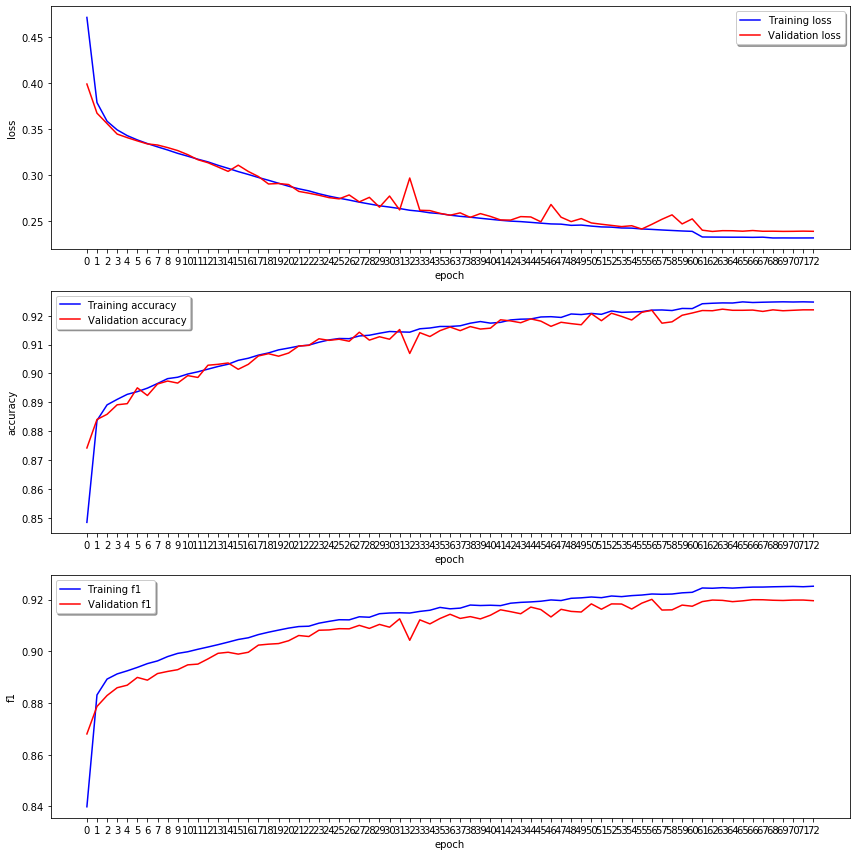

Test loss: 0.238
Test accuracy: 0.922
Test F1: 0.92


In [35]:
loss, accuracy, get_f1  = model.evaluate(X_test, y_test, verbose=False)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history.history['get_f1'], color='b', label="Training f1")
ax3.plot(history.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')


In [36]:
predictions = model.predict(X_test)

In [37]:
# Predykcje są zakodowane w one-hot encoderze, to zamienia wyjście na maxa i zmienia kształt na tabele

predictions = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], predictions)))
predictions = numpy.reshape(predictions, (y_test.shape[0],))

y_pred = predictions

In [38]:
# Etykieta activity jest zakodowana w one-hot encoderze, to zamienia wyjście na maxa i zmienia kształt na tabele
tmp = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], y_test)))
tmp = numpy.reshape(tmp, (y_test.shape[0],))

y_true = tmp

In [39]:
cm = confusion_matrix(y_true, y_pred)

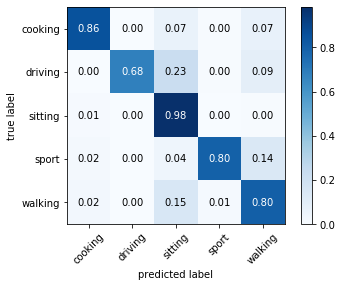

In [40]:
plot_cm(cm, ['cooking', 'driving', 'sitting', 'sport', 'walking'])

In [41]:
print(cm)

[[1057    0   82    5   90]
 [   0  174   58    1   24]
 [  75   16 8048    2   39]
 [   6    0   16  300   54]
 [  65   10  417   39 2185]]


In [42]:
accuracy, precision, recall, fscore = countStats(y_true, y_pred)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.9217268667241244
Precision: 0.9206434738187681
Recall: 0.9217268667241244
F-score: 0.9197311108620777


# Prep func

In [52]:
def load_data(link, mag=True):
    
    df = pd.read_csv(link, index_col = 0)
    tmp = df.pop('activity')
    df['activity'] = tmp
    
    if not mag:
        df.pop('magnetometer#mean')
        df.pop('magnetometer#std')
        df.pop('magnetometer#min')
        df.pop('magnetometer#max')

    df.dropna(inplace=True)
    df.head()
    
    df = df.replace({'activity':'cooking'},{'activity':0})
    df = df.replace({'activity':'driving'},{'activity':1})
    df = df.replace({'activity':'sitting'},{'activity':2})
    df = df.replace({'activity':'sport'},{'activity':3})
    df = df.replace({'activity':'walking'},{'activity':4})
    
    X, y = df.iloc[:, 0:-1], df.iloc[:, -1]
    
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
    result = next(kf.split(X, y))

    train = df.iloc[result[0]]
    test =  df.iloc[result[1]]

    X_train = train.drop('activity', axis = 1)
    y_train = train.activity

    X_test = test.drop('activity', axis = 1)
    y_test = test.activity
    
    df = df.to_numpy()

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()

    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    num_classes = 5

    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    X_train = numpy.expand_dims(X_train, axis=1)
    y_train = numpy.expand_dims(y_train, axis=1)

    X_test = numpy.expand_dims(X_test, axis=1)
    y_test = numpy.expand_dims(y_test, axis=1)
    
    return X_train, y_train, X_test, y_test

def comp(model, X_train, y_train, X_test, y_test):
    '''
    cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
    cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
    cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
    '''

    EARLY_STOP_PATIENCE = 10
    LEARNING_RATE_PATIENCE = 5

    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
    cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
    cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

    epochs = grid_result['epochs']
    batch_size = grid_result['batch_size']
    optimizer = grid_result['optimizer']
    activation = grid_result['activation']
    dropout = grid_result['dropout_rate']
    loss_type = 'categorical_crossentropy'
    LSTM_size = 128
    
    model.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(x=X_train,
                        y=y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size, 
                        callbacks=[cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction])

    model.load_weights('best.h5')

    model.save('the_best.h5')
    
    loss, accuracy= model.evaluate(X_test, y_test, verbose=False)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
    ax1.set_xticks(numpy.arange(0, len(history.history['val_loss']), 1))
    ax1.legend(loc='best', shadow=True)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(numpy.arange(0, len(history.history['val_accuracy']), 1))
    ax2.legend(loc='best', shadow=True)
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')


    plt.tight_layout()
    plt.show()

    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

    predictions = model.predict(X_test)
    
    predictions = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], predictions)))
    predictions = numpy.reshape(predictions, (y_test.shape[0],))

    y_pred = predictions
    
    tmp = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], y_test)))
    tmp = numpy.reshape(tmp, (y_test.shape[0],))

    y_true = tmp
    
    cm = confusion_matrix(y_true, y_pred)
    
    plot_cm(cm, ['cooking', 'driving', 'sitting', 'sport', 'walking'])
    
    print(cm)
    
    accuracy, precision, recall, fscore = countStats(y_true, y_pred)
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')
    
def run(link, mag):
    
    X_train, y_train, X_test, y_test = load_data(link, mag)
    
    model = Sequential()
    model.add(LSTM(LSTM_size, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True))
    model.add(Dense(5, activation='softmax'))
    
    comp(model, X_train, y_train, X_test, y_test)

# Dane z magnetometrem

Train on 84272 samples, validate on 21069 samples
Epoch 1/100
84272/84272 [==============================] - 14s 164us/step - loss: 0.1445 - accuracy: 0.9490 - val_loss: 0.0815 - val_accuracy: 0.9702

Epoch 00001: val_loss improved from inf to 0.08153, saving model to best.h5
Epoch 2/100
84272/84272 [==============================] - 13s 159us/step - loss: 0.0731 - accuracy: 0.9735 - val_loss: 0.0679 - val_accuracy: 0.9749

Epoch 00002: val_loss improved from 0.08153 to 0.06792, saving model to best.h5
Epoch 3/100
84272/84272 [==============================] - 14s 162us/step - loss: 0.0582 - accuracy: 0.9786 - val_loss: 0.0455 - val_accuracy: 0.9843

Epoch 00003: val_loss improved from 0.06792 to 0.04551, saving model to best.h5
Epoch 4/100
84272/84272 [==============================] - 13s 157us/step - loss: 0.0522 - accuracy: 0.9809 - val_loss: 0.0527 - val_accuracy: 0.9805

Epoch 00004: val_loss did not improve from 0.04551
Epoch 5/100
84272/84272 [==============================] - 

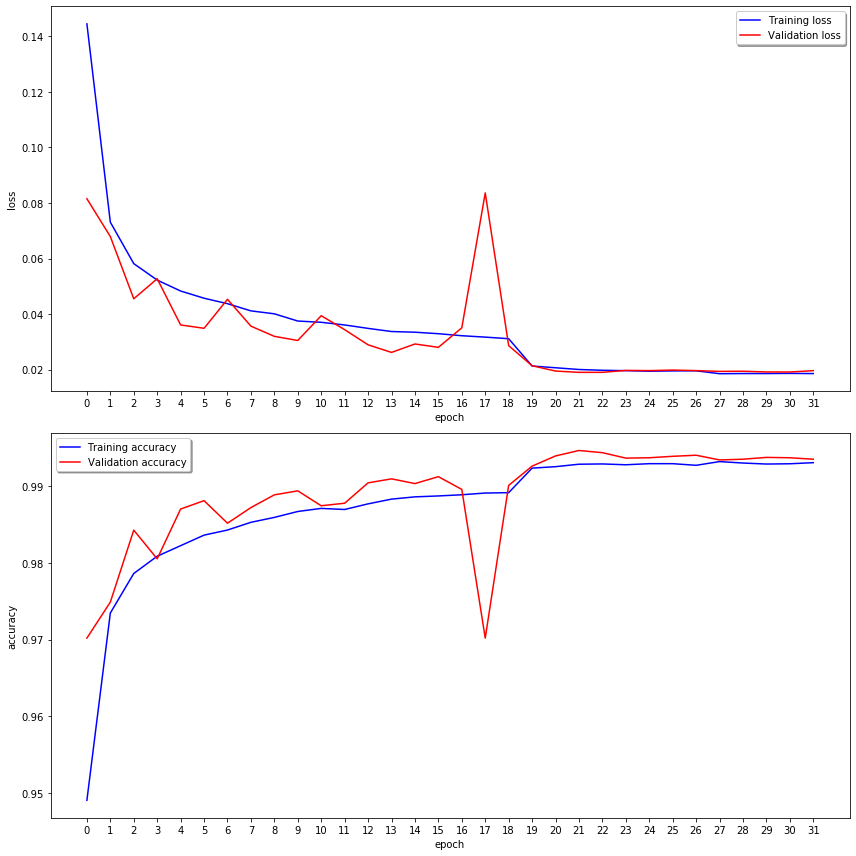

Test loss: 0.019
Test accuracy: 0.995
[[4945    3   25    0   10]
 [   2 2597    1    0    0]
 [  52    2 5427    0    1]
 [   0    0    0 4725    0]
 [  12    0    3    1 3263]]
Accuracy: 0.9946841330865253
Precision: 0.9946944728252107
Recall: 0.9946841330865253
F-score: 0.9946858959668322


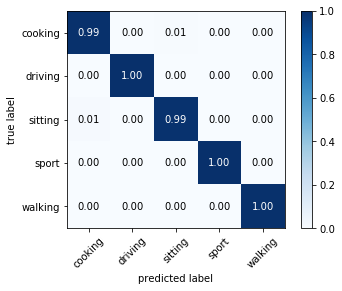

In [53]:
run("data//data_real_5s_without_step_12_06.csv", True)

# Dane bez magnetometru

Train on 84272 samples, validate on 21069 samples
Epoch 1/100
84272/84272 [==============================] - 14s 169us/step - loss: 0.3016 - accuracy: 0.8769 - val_loss: 0.2196 - val_accuracy: 0.9055

Epoch 00001: val_loss improved from inf to 0.21963, saving model to best.h5
Epoch 2/100
84272/84272 [==============================] - 14s 166us/step - loss: 0.1822 - accuracy: 0.9290 - val_loss: 0.1477 - val_accuracy: 0.9492

Epoch 00002: val_loss improved from 0.21963 to 0.14770, saving model to best.h5
Epoch 3/100
84272/84272 [==============================] - 14s 168us/step - loss: 0.1538 - accuracy: 0.9407 - val_loss: 0.1311 - val_accuracy: 0.9549

Epoch 00003: val_loss improved from 0.14770 to 0.13107, saving model to best.h5
Epoch 4/100
84272/84272 [==============================] - 14s 167us/step - loss: 0.1408 - accuracy: 0.9469 - val_loss: 0.1234 - val_accuracy: 0.9579

Epoch 00004: val_loss improved from 0.13107 to 0.12342, saving model to best.h5
Epoch 5/100
84272/84272 [=====

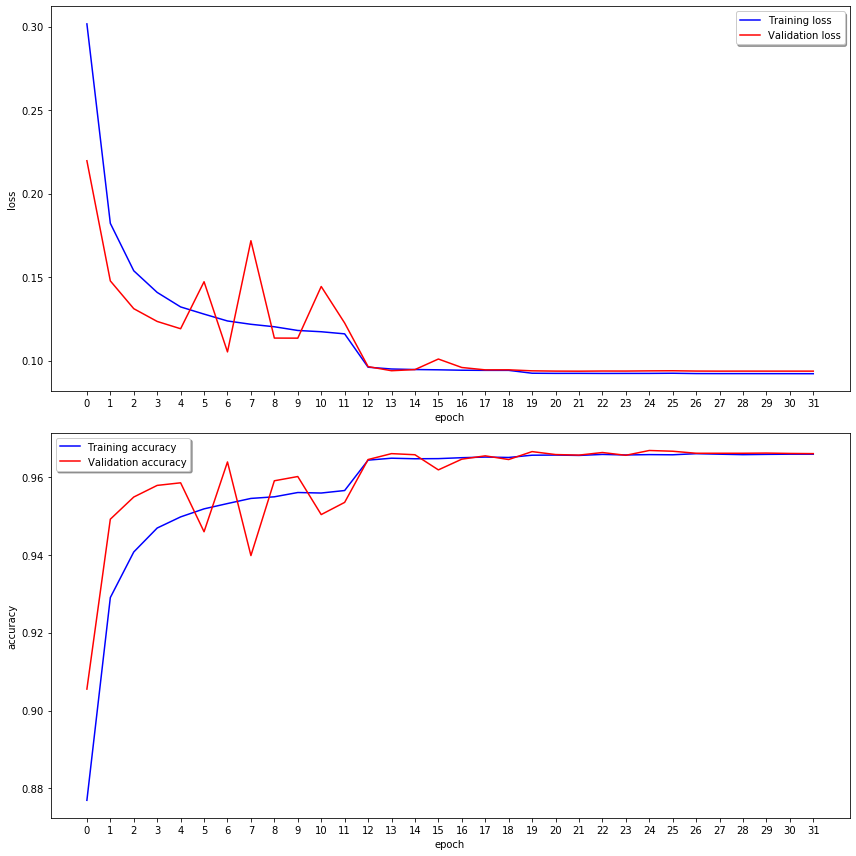

Test loss: 0.0936
Test accuracy: 0.966
[[4720  201   48    0   14]
 [ 287 2282   15    0   16]
 [ 115   13 5352    0    2]
 [   0    0    0 4725    0]
 [  10    1    2    0 3266]]
Accuracy: 0.9656367174521809
Precision: 0.9657552597675314
Recall: 0.9656367174521809
F-score: 0.9655925614857553


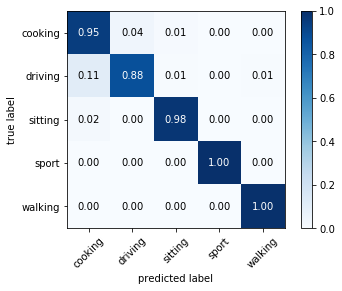

In [54]:
run("data//data_real_5s_without_step_12_06.csv", False)

# Znormalizownae dane z magnetometrem

Train on 84272 samples, validate on 21069 samples
Epoch 1/100
84272/84272 [==============================] - 14s 168us/step - loss: 0.1813 - accuracy: 0.9555 - val_loss: 0.1090 - val_accuracy: 0.9729

Epoch 00001: val_loss improved from inf to 0.10902, saving model to best.h5
Epoch 2/100
84272/84272 [==============================] - 14s 165us/step - loss: 0.0857 - accuracy: 0.9784 - val_loss: 0.0546 - val_accuracy: 0.9821

Epoch 00002: val_loss improved from 0.10902 to 0.05459, saving model to best.h5
Epoch 3/100
84272/84272 [==============================] - 14s 164us/step - loss: 0.0554 - accuracy: 0.9832 - val_loss: 0.0451 - val_accuracy: 0.9846

Epoch 00003: val_loss improved from 0.05459 to 0.04509, saving model to best.h5
Epoch 4/100
84272/84272 [==============================] - 14s 165us/step - loss: 0.0512 - accuracy: 0.9844 - val_loss: 0.0446 - val_accuracy: 0.9860

Epoch 00004: val_loss improved from 0.04509 to 0.04461, saving model to best.h5
Epoch 5/100
84272/84272 [=====

84272/84272 [==============================] - 14s 170us/step - loss: 0.0331 - accuracy: 0.9903 - val_loss: 0.0280 - val_accuracy: 0.9906

Epoch 00038: val_loss improved from 0.02817 to 0.02797, saving model to best.h5
Epoch 39/100
84272/84272 [==============================] - 14s 167us/step - loss: 0.0330 - accuracy: 0.9902 - val_loss: 0.0277 - val_accuracy: 0.9906

Epoch 00039: val_loss improved from 0.02797 to 0.02771, saving model to best.h5
Epoch 40/100
84272/84272 [==============================] - 14s 168us/step - loss: 0.0330 - accuracy: 0.9902 - val_loss: 0.0275 - val_accuracy: 0.9906

Epoch 00040: val_loss improved from 0.02771 to 0.02748, saving model to best.h5
Epoch 41/100
84272/84272 [==============================] - 14s 168us/step - loss: 0.0331 - accuracy: 0.9902 - val_loss: 0.0276 - val_accuracy: 0.9906

Epoch 00041: val_loss did not improve from 0.02748
Epoch 42/100
84272/84272 [==============================] - 14s 167us/step - loss: 0.0331 - accuracy: 0.9901 - val

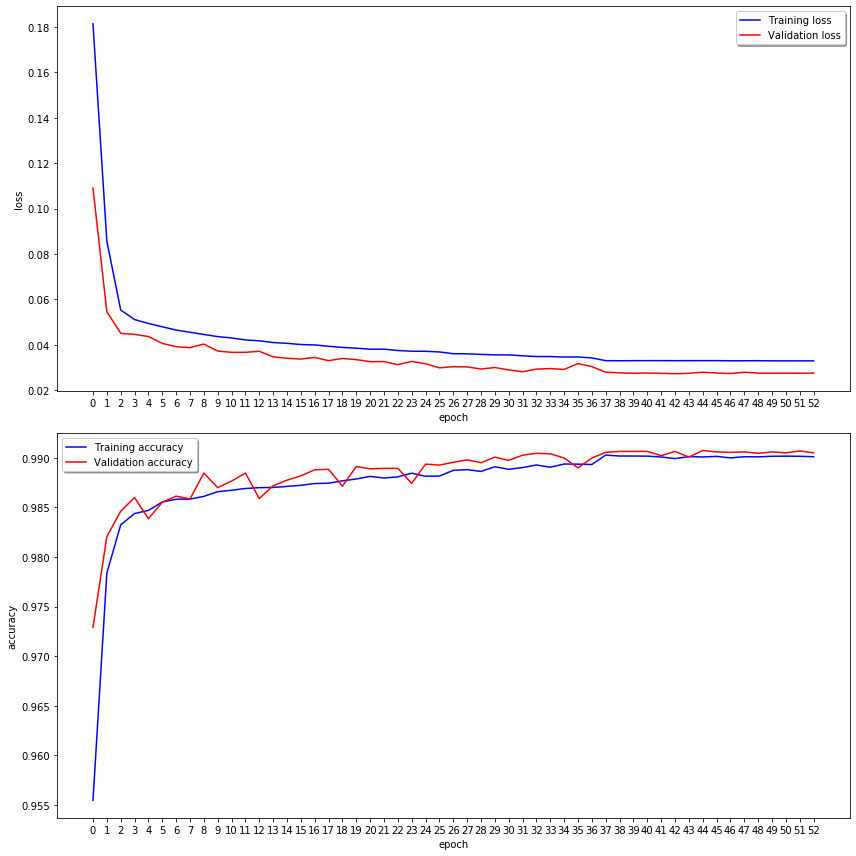

Test loss: 0.0273
Test accuracy: 0.991
[[4914    1   49    0   19]
 [   7 2583   10    0    0]
 [  90    9 5381    0    2]
 [   0    0    0 4725    0]
 [   8    0    2    0 3269]]
Accuracy: 0.9906497698039775
Precision: 0.990666286511539
Recall: 0.9906497698039775
F-score: 0.9906509231757189


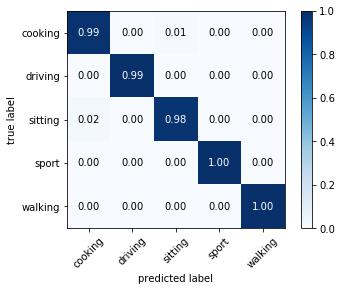

In [55]:
run("data//data_real_5s_without_step_12_06_normalized.csv", True)

# Znormalizownae dane bez magnetometru

Train on 84272 samples, validate on 21069 samples
Epoch 1/100
84272/84272 [==============================] - 14s 163us/step - loss: 0.2952 - accuracy: 0.9124 - val_loss: 0.1972 - val_accuracy: 0.9476

Epoch 00001: val_loss improved from inf to 0.19724, saving model to best.h5
Epoch 2/100
84272/84272 [==============================] - 14s 161us/step - loss: 0.1616 - accuracy: 0.9491 - val_loss: 0.1433 - val_accuracy: 0.9561

Epoch 00002: val_loss improved from 0.19724 to 0.14334, saving model to best.h5
Epoch 3/100
84272/84272 [==============================] - 13s 157us/step - loss: 0.1374 - accuracy: 0.9551 - val_loss: 0.1360 - val_accuracy: 0.9568

Epoch 00003: val_loss improved from 0.14334 to 0.13596, saving model to best.h5
Epoch 4/100
84272/84272 [==============================] - 14s 164us/step - loss: 0.1323 - accuracy: 0.9562 - val_loss: 0.1355 - val_accuracy: 0.9508

Epoch 00004: val_loss improved from 0.13596 to 0.13550, saving model to best.h5
Epoch 5/100
84272/84272 [=====

84272/84272 [==============================] - 13s 159us/step - loss: 0.0981 - accuracy: 0.9638 - val_loss: 0.0979 - val_accuracy: 0.9665

Epoch 00038: val_loss did not improve from 0.09707
Epoch 39/100
84272/84272 [==============================] - 13s 158us/step - loss: 0.0976 - accuracy: 0.9648 - val_loss: 0.0980 - val_accuracy: 0.9617

Epoch 00039: val_loss did not improve from 0.09707
Epoch 40/100
84272/84272 [==============================] - 13s 158us/step - loss: 0.0975 - accuracy: 0.9647 - val_loss: 0.0968 - val_accuracy: 0.9656

Epoch 00040: val_loss improved from 0.09707 to 0.09679, saving model to best.h5
Epoch 41/100
84272/84272 [==============================] - 13s 158us/step - loss: 0.0970 - accuracy: 0.9644 - val_loss: 0.0964 - val_accuracy: 0.9670

Epoch 00041: val_loss improved from 0.09679 to 0.09643, saving model to best.h5
Epoch 42/100
84272/84272 [==============================] - 13s 159us/step - loss: 0.0969 - accuracy: 0.9645 - val_loss: 0.0975 - val_accuracy:

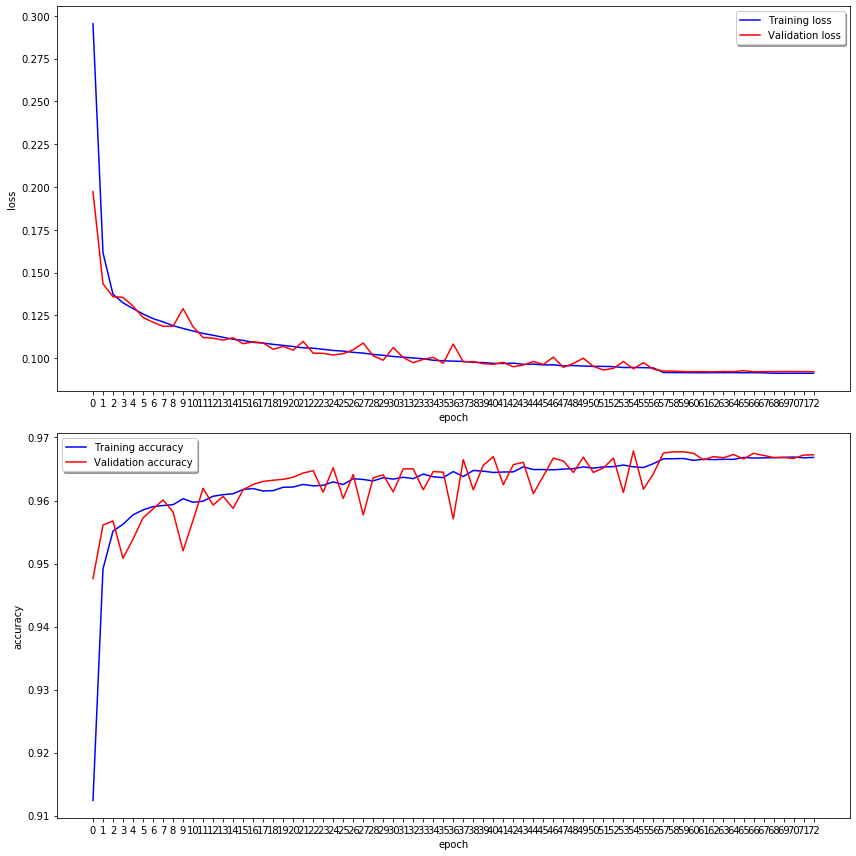

Test loss: 0.0921
Test accuracy: 0.967
[[4717  192   60    0   14]
 [ 236 2328   18    0   18]
 [ 113   30 5339    0    0]
 [   0    0    0 4725    0]
 [   8    6    1    0 3264]]
Accuracy: 0.9669656841805496
Precision: 0.9670468280958601
Recall: 0.9669656841805496
F-score: 0.9669701535258015


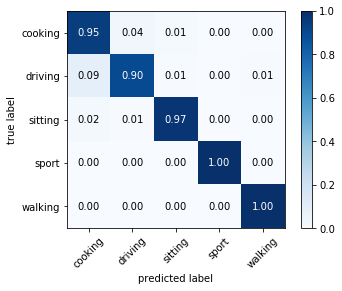

In [56]:
run("data//data_real_5s_without_step_12_06_normalized.csv", False)